In [12]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/embeddings/biasbios")
import classifier
import svm_classifier
import debias
# import gensim
import codecs
import json
# from gensim.models.keyedvectors import Word2VecKeyedVectors
# from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

# import torch
# from torch import utils

# import pytorch_lightning as pl
# from pytorch_lightning import Trainer
import copy

import seaborn as sn
import pandas as pd


PROFS = ['professor', 'physician', 'attorney', 'photographer', 'journalist', 'nurse', 'psychologist', 'teacher',
'dentist', 'surgeon', 'architect', 'painter', 'model', 'poet', 'filmmaker', 'software_engineer',
'accountant', 'composer', 'dietitian', 'comedian', 'chiropractor', 'pastor', 'paralegal', 'yoga_teacher',
'dj', 'interior_designer', 'personal_trainer', 'rapper']

PROF2UNIFIED_PROF = {"associate professor": "professor", "assistant professor": "professor", "software engineer": "software_engineer", "psychotherapist": "psychologist", "orthopedic surgeon": "surgeon", "trial lawyer": "attorney","plastic surgeon": "surgeon",  "trial attorney": "attorney", "senior software engineer": "software_engineer", "interior designer": "interior_designer", "certified public accountant": "accountant", "cpa": "accountant", "neurosurgeon": "surgeon", "yoga teacher": "yoga_teacher", "nutritionist": "dietitian", "personal trainer": "personal_trainer", "certified personal trainer": "personal_trainer", "yoga instructor": "yoga_teacher"}

In [4]:
def load_data(fname = "/home/nlp/ravfogs/gender/biosbias/BIOS.pkl"):
    with open(fname, "rb") as f:
        data = pickle.load(f)
    for i, data_dict in enumerate(data):
        
        prof = data_dict["raw_title"].lower()
        data[i]["raw_title"] = PROF2UNIFIED_PROF[prof] if prof in PROF2UNIFIED_PROF else prof
    
    return data
        
        
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["gender"], entry["raw_title"]
        counter[prof.lower()][gender.lower()] += 1
        
    return counter

def filter_dataset(data, topk = 10):
    
    filtered = []
    counter = count_profs_and_gender(data)
    total_counts = [(prof, counter[prof]["f"] + counter[prof]["m"]) for prof in counter.keys()]
    profs_by_frq = sorted(total_counts, key = lambda x: -x[1])
    topk_profs = [p[0] for p in profs_by_frq[:topk]]
    
    print("Top-k professions: {}".format(topk_profs))
    for d in data:
        
        if d["raw_title"].lower() in topk_profs:
            filtered.append(d)
    
    return filtered
    
def split_train_dev_test(data):
    
    g2i, i2g = {"m": 0, "f": 1}, {1: "f", 0: "m"}
    all_profs = list(set([d["raw_title"] for d in data]))
    all_words = []
    for d in data:
        all_words.extend(d["raw"].split(" "))
    
    all_words = set(all_words)
    all_words.add("<UNK>")
    
    p2i = {p:i for i,p in enumerate(sorted(all_profs))}
    i2p = {i:p for i,p in enumerate(sorted(all_profs))}
    w2i = {w:i for i,w in enumerate(sorted(all_words))}
    i2w = {i:w for i,w in enumerate(sorted(all_words))}
    
    all_data = []
    for entry in tqdm.tqdm(data, total = len(data)):
        gender, prof = entry["gender"].lower(), entry["raw_title"].lower()
        #if prof in PROF2UNITED_PROF: prof = PROF2UNITED_PROF[prof]
        raw, start_index = entry["raw"], entry["start_pos"]
        all_data.append({"g": g2i[gender], "p": p2i[prof], "text": raw, "start": start_index})


    train_dev, test = sklearn.model_selection.train_test_split(all_data, test_size = 0.2, random_state = 0)
    train, dev = sklearn.model_selection.train_test_split(train_dev, test_size = 0.3, random_state = 0)
    print("Train size: {}; Dev size: {}; Test size: {}".format(len(train), len(dev), len(test)))
    return (train, dev, test), (g2i, i2g, p2i, i2p, w2i, i2w)


In [5]:
data = load_data()
data = filter_dataset(data, topk = 60)
(train, dev, test), (g2i, i2g, p2i, i2p, w2i, i2w) = split_train_dev_test(data)

Top-k professions: ['professor', 'physician', 'attorney', 'photographer', 'journalist', 'nurse', 'psychologist', 'teacher', 'surgeon', 'architect', 'dentist', 'painter', 'model', 'poet', 'filmmaker', 'software_engineer', 'composer', 'accountant', 'dietitian', 'comedian', 'pastor', 'chiropractor', 'yoga_teacher', 'paralegal', 'interior_designer', 'dj', 'rapper', 'personal_trainer']


100%|██████████| 256682/256682 [00:00<00:00, 529348.82it/s]


Train size: 143741; Dev size: 61604; Test size: 51337


In [6]:
def normalize_text(data):
    for entry in data:
        text, start, y = entry["text"], entry["start"], entry["p"]
        #text = text.lower()
        words = text[start + 1:].split(" ")
        entry['hard_text'] = ' '.join(words)
    return data

In [7]:
train = normalize_text(train)
dev = normalize_text(dev)

In [8]:
train[0]

{'g': 0,
 'p': 1,
 'text': '"Steven Ehrlich is a world-renowned architect based in Culver City. Not surprisingly, his firm’s design is visually striking. While it has a modern edge, it uses warm materials like brick and wood. Ehrlich’s design is extroverted and open. One particular strength of this proposal is the manner in which it preserved the “view corridors” to the Culver Studios mansion. The taller portion of the project, which will contain its office component, is on the east portion of the site. The only view it blocks is of the Ince Parking structure. The \'grand staircase\' and public plaza on the second floor are generous extensions of what will be an expanded and improved Town Plaza."',
 'start': 67,
 'hard_text': 'Not surprisingly, his firm’s design is visually striking. While it has a modern edge, it uses warm materials like brick and wood. Ehrlich’s design is extroverted and open. One particular strength of this proposal is the manner in which it preserved the “view corr

In [9]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


### get input representatons 

In [10]:
def get_BOW_based_dataset(data: List[dict], w2i):
    
    vectorizer = DictVectorizer(sparse = True)
    X, Y = [], []
    unk, total = 0., 0.
    data_dicts = []
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, start, y = entry["text"], entry["start"], entry["p"]
        #text = text.lower()
        words = text[start + 1:].split(" ")
        entry_dict = {w:w2i[w] if w in w2i else w2i["<UNK>"] for w in words}
        data_dicts.append(entry_dict)
        Y.append(y)
        
        total += len(words)
        unk += len([w for w in words if w not in w2i])
    
    print("% unknown: {}".format(unk/total))
    X = vectorizer.fit_transform(data_dicts)
    return X,Y

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform([x['text'] for x in train])
X_train_counts.shape

(143741, 222635)

In [13]:
len(dev)

61604

In [14]:
train[100]

{'g': 1,
 'p': 19,
 'text': 'Ms. Autumn B. Spencer is a practicing physician. Ms. Spencer practices medicine in Austin, TX and specializes in Neurological Surgery. Ms. Spencer is affiliated with University Medical Center Brackenridge, Seton Medical Center Williamson and Seton Medical Center Austin. Ms. Spencer speaks English and Spanish.',
 'start': 48,
 'hard_text': 'Ms. Spencer practices medicine in Austin, TX and specializes in Neurological Surgery. Ms. Spencer is affiliated with University Medical Center Brackenridge, Seton Medical Center Williamson and Seton Medical Center Austin. Ms. Spencer speaks English and Spanish.'}

In [15]:
x_train = [x['hard_text'] for x in train]
y_train = [x['p'] for x in train]

x_dev = [x['hard_text'] for x in dev]
y_dev = [x['p'] for x in dev]

clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('selection', SelectKBest(chi2, k=30000)),
    ('classifier', LogisticRegression())
])

clf.fit(x_train, y_train)
clf.score(x_dev, y_dev)

0.7888448802025843

In [37]:
# vectorizer = CountVectorizer()
# vectorizer.fit(x_train, y_train)

# classifier = LinearSVC()
# classifier.fit(vectorizer.transform(x_train) , y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

#### Confusion Matrix

In [16]:
y_hat = clf.predict(x_dev)
cm = sklearn.metrics.confusion_matrix(y_dev,y_hat)
labels = [i2p[i] for i in range(len(i2p))]

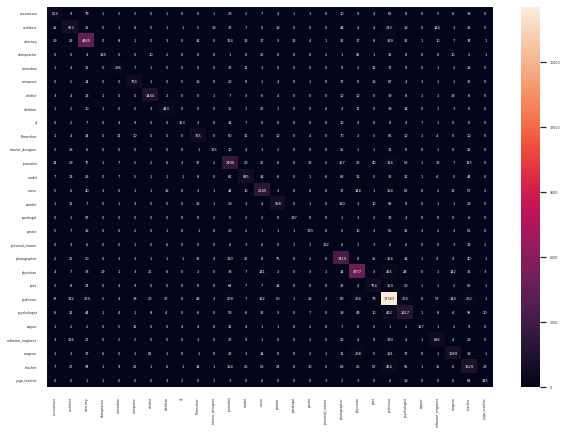

In [17]:
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
#plt.figure(figsize = (10,7))
sn.set(font_scale=0.3)#for label size
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
# plt.savefig("confusion.png", dpi = 600)
plt.show()

### feature inspection

In [18]:
import eli5
# eli5.show_weights(clf)

### perform debiasing

In [19]:
def get_projection_matrix(num_clfs, X_train, Y_train, X_dev, Y_dev, dim=300):

    is_autoregressive = True
    siamese = False
    reg = "l1"
    min_acc = 0.
    noise = False
    random_subset = False
    regression = False

    P = debias.get_debiasing_projection(None, num_clfs, dim, is_autoregressive, min_acc, X_train, Y_train, X_dev, Y_dev,
                                              noise = noise, random_subset = random_subset,
                                              regression = regression, siamese = siamese, siamese_dim = 1)
    return P



num_clfs = 50
Y_dev_gender = np.array([d["g"] for d in dev])
Y_train_gender = np.array([d["g"] for d in train])

In [21]:
x_train_one_hot = clf.named_steps['selection'].transform(clf.named_steps['vectorizer'].transform([x['hard_text'] for x in train[:1000]]))
x_dev_one_hot = clf.named_steps['selection'].transform(clf.named_steps['vectorizer'].transform([x['hard_text'] for x in dev[:1000]]))

In [22]:
x_train_one_hot

<1000x30000 sparse matrix of type '<class 'numpy.int64'>'
	with 40974 stored elements in Compressed Sparse Row format>

In [23]:
x_train_one_hot.shape

(1000, 30000)

In [33]:
clf.named_steps

{'vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'selection': SelectKBest(k=30000, score_func=<function chi2 at 0x7f8d61fc3158>),
 'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False)}

In [ ]:
P = get_projection_matrix(num_clfs, x_train_one_hot, 
                          Y_train_gender[:1000], x_dev_one_hot, Y_dev_gender[:1000], dim = 30000)

Iteration 0, Accuracy: 0.998
Iteration 1, Accuracy: 0.776


In [52]:
P

array([[ 9.95073935e-01, -4.71892896e-04,  7.29501633e-05, ...,
         3.30211536e-04,  3.30117471e-04,  3.30106920e-04],
       [-4.71334669e-04,  9.99107475e-01,  9.58652444e-05, ...,
         1.23413208e-04,  1.23306813e-04,  1.23294632e-04],
       [ 7.27299525e-05,  9.56548055e-05,  9.99951907e-01, ...,
        -1.16701920e-05, -1.16638782e-05, -1.16631075e-05],
       ...,
       [ 3.28737166e-04,  1.22626651e-04, -1.19180583e-05, ...,
         9.99668559e-01, -3.31315512e-04, -3.31305300e-04],
       [ 3.28652868e-04,  1.22524825e-04, -1.19098494e-05, ...,
        -3.31313749e-04,  9.99668811e-01, -3.31178954e-04],
       [ 3.28643161e-04,  1.22513039e-04, -1.19089150e-05, ...,
        -3.31303385e-04, -3.31178802e-04,  9.99668831e-01]])

In [198]:
P.shape

(11310, 11310)

In [202]:
(np.array([[3, 3], [3, 4]])).dot(np.array([1, 1]))

array([6, 7])

In [197]:
(vectorizer.transform(x_dev[:1]) * P).shape

(1, 11310)

In [ ]:
# WxP

# W: N*1
# x: 1*N
# P: N*N

### New model - with debisaing

In [74]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DebiasClassifier(BaseEstimator, ClassifierMixin):  
    """An example of classifier"""

    def __init__(self, w):
        """
        Called when initializing the classifier
        """
        self.w = w

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.

        Note: assert is not a good choice here and you should rather
        use try/except blog with exceptions. This is just for short syntax.
        """

        raise Exception

    def _meaning(self, x):
        # returns True/False according to fitted classifier
        # notice underscore on the beginning
        return( True if x >= self.treshold_ else False )

    def predict(self, X, y=None):
        return X * self.w
    
    def transform(self, X):
        return X * self.w

    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X))) 

In [90]:
from eli5 import transform_feature_names

@transform_feature_names.register(DebiasClassifier)
def indexer_feature_names(transformer, in_names=None):
    assert in_names is not None  # don't handle it for now
    print(transformer)
    return ["StringIndexer(%s)" % name for name in in_names]

In [94]:
debias_clf.named_steps

{'vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'debiaser': DebiasClassifier(w=array([[ 9.95074e-01, -4.71893e-04, ...,  3.30117e-04,  3.30107e-04],
        [-4.71335e-04,  9.99107e-01, ...,  1.23307e-04,  1.23295e-04],
        ...,
        [ 3.28653e-04,  1.22525e-04, ...,  9.99669e-01, -3.31179e-04],
        [ 3.28643e-04,  1.22513e-04, ..., -3.31179e-04,  9.99669e-01]])),
 'classifier': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0)}

In [151]:
svc = clf.named_steps['classifier']

In [209]:
from copy import deepcopy

debiased_svc = deepcopy(svc)

In [156]:
svc.coef_.shape

(28, 11310)

In [161]:
P.shape

(11310, 11310)

In [164]:
svc.coef_.dot(P).shape

(28, 11310)

In [208]:
svc.coef_.dot(P.T).shape

(28, 11310)

In [159]:
debiased_svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [210]:
debiased_svc.coef_ = svc.coef_.dot(P.T)

In [192]:
P.dot(svc.coef_.T).shape

(11310, 28)

In [168]:
debiased_svc.coef_

array([[-1.44686982e-02,  1.23219407e-03, -3.15095742e-04, ...,
        -2.83134341e-04, -2.83137862e-04, -2.83138834e-04],
       [-1.07306851e-02, -1.48403201e-05, -1.54039274e-04, ...,
        -1.41048651e-03, -1.41056475e-03, -1.41058473e-03],
       [-2.77118299e-03, -1.48543797e-02, -4.80691961e-05, ...,
        -1.94320868e-03, -1.94336153e-03, -1.94340424e-03],
       ...,
       [-3.85608484e-03, -1.21734168e-03,  5.68716029e-05, ...,
        -7.06462000e-04, -7.06455298e-04, -7.06450199e-04],
       [ 4.45547979e-02,  2.39314159e-02, -2.83270345e-03, ...,
        -9.62377915e-04, -9.62385575e-04, -9.62382874e-04],
       [-1.21913521e-04, -3.86392386e-03, -4.07343369e-07, ...,
        -3.84823571e-04, -3.84816705e-04, -3.84814371e-04]])

In [170]:
debias_clf = Pipeline([
    ('vectorizer', clf.named_steps['vectorizer']),
    ('classifier', debiased_svc),
])

In [350]:
eli5.show_weights(clf, target_names=list(p2i.keys()))

In [211]:
eli5.show_weights(debias_clf, target_names=list(p2i.keys()))

In [243]:
eli5.show_prediction(clf.named_steps['classifier'] , x_dev[8], vec=clf.named_steps['vectorizer'],
                    target_names=list(p2i.keys()))

In [244]:
eli5.show_prediction(debias_clf.named_steps['classifier'] , x_dev[8], vec=debias_clf.named_steps['vectorizer'],
                    target_names=list(p2i.keys()))

#### test model without finetuning

In [148]:
debias_clf.score(x_dev, y_dev)

0.899

In [258]:
reg_cls = clf.named_steps['classifier']
debias_cls = debias_clf.named_steps['classifier']

In [255]:
reg_cls.coef_.shape

(28, 11310)

In [261]:
reg_cls.coef_ 

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [264]:
reg_cls.coef_

array([[-0.01604257,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01681018,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00634611, -0.0155533 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.01007608, -0.00153621,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04466315,  0.02277853, -0.00302302, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00279181, -0.0042028 ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [265]:
debias_cls.coef_

array([[-1.44686982e-02,  1.23219407e-03, -3.15095742e-04, ...,
        -2.83134341e-04, -2.83137862e-04, -2.83138834e-04],
       [-1.07306851e-02, -1.48403201e-05, -1.54039274e-04, ...,
        -1.41048651e-03, -1.41056475e-03, -1.41058473e-03],
       [-2.77118299e-03, -1.48543797e-02, -4.80691961e-05, ...,
        -1.94320868e-03, -1.94336153e-03, -1.94340424e-03],
       ...,
       [-3.85608484e-03, -1.21734168e-03,  5.68716029e-05, ...,
        -7.06462000e-04, -7.06455298e-04, -7.06450199e-04],
       [ 4.45547979e-02,  2.39314159e-02, -2.83270345e-03, ...,
        -9.62377915e-04, -9.62385575e-04, -9.62382874e-04],
       [-1.21913521e-04, -3.86392386e-03, -4.07343369e-07, ...,
        -3.84823571e-04, -3.84816705e-04, -3.84814371e-04]])

In [279]:
((reg_cls.coef_ * debias_cls.coef_) < 0)[0]

array([False, False, False, ..., False, False, False])

In [283]:
sum(((reg_cls.coef_ * debias_cls.coef_) < 0)[0])

253

In [281]:
np.select(((reg_cls.coef_ * debias_cls.coef_) < 0)[0], vectorizer.get_feature_names())

array('0500', dtype='<U23')

In [294]:
feat_names = np.array(vectorizer.get_feature_names())

In [309]:
feat_names

array(['00', '000', '004lp', ..., 'በዓባይ', 'ነፍስ', 'አድን'], dtype='<U23')

In [315]:
did_change = ((reg_cls.coef_ * debias_cls.coef_) < 0)[2]

In [311]:
did_change

array([False, False, False, ..., False, False, False])

In [296]:
did_change.shape

(11310,)

In [301]:
feat_names.shape

(11310,)

In [316]:
feat_names[did_change]

array(['1000', '1876', '1940', '1997', '1998', '2001', '2015', '217',
       '24', '333', '37', '45', '5557', '57', '70', 'accomplished',
       'achieve', 'activities', 'adelaide', 'adheres', 'advance',
       'advertising', 'affected', 'afghan', 'afropop', 'alejandra',
       'alex', 'alexa', 'amanda', 'analytic', 'analytics', 'anthony',
       'any', 'apache', 'approaches', 'arab', 'architecturally', 'aria',
       'art', 'ashamed', 'asharq', 'assessed', 'associations', 'atlantic',
       'attacks', 'attend', 'august', 'austin', 'australia', 'austria',
       'autumn', 'awsat', 'bachelors', 'background', 'baillargeon',
       'bakir', 'balance', 'beacon', 'because', 'beer', 'before',
       'belmont', 'below', 'benjamin', 'beyond', 'bezner', 'binghamton',
       'bio', 'bluff', 'booking', 'brackenridge', 'brennpunkt',
       'bringing', 'broaden', 'called', 'calling', 'calypso', 'canada',
       'capitalist', 'cardinal', 'carl', 'carnival', 'caroline', 'cecil',
       'celebrates', 

In [298]:
a = np.array([True, True, True, False, False])
b = np.array([[1,2,3,4,5], [1,2,3,4,5]])
b[:,a]

array([[1, 2, 3],
       [1, 2, 3]])

In [285]:
np.array(vectorizer.get_feature_names())[:, ((reg_cls.coef_ * debias_cls.coef_) < 0)[0]]

IndexError: too many indices for array

In [277]:
vectorizer.get_feature_names()

TypeError: 'list' object is not callable

In [269]:
len(vectorizer.get_feature_names())

11310

### Features Flip

In [ ]:
def flip_features(clf1, clf2, feature_names):
    (clf1.coef_ * clf2.coef_) < 0

### Perform finetuning

In [ ]:
clf.fit(X_train.dot(P), Y_train)

#### test again

In [ ]:
print(clf.score(X_dev.dot(P), Y_dev))